In [4]:
##############################
#  Using an RNN/LSTM to Forecast the Number of Confirmed Cases of COVID 19#
##############################

In [157]:
#data accessed through
#https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv('time_series_covid19_confirmed_global.txt',delimiter=',')

In [63]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,1,2,2,3,3,3,4,4


In [64]:
#all we need is the time-series data, do not need the first four columns in this case
df = df.iloc[:,4:]

In [65]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,0,0,0,0,0,0,0,0,0,0,...,22,22,24,24,40,40,74,84,94,110
1,0,0,0,0,0,0,0,0,0,0,...,59,64,70,76,89,104,123,146,174,186
2,0,0,0,0,0,0,0,0,0,0,...,74,87,90,139,201,230,264,302,367,409
3,0,0,0,0,0,0,0,0,0,0,...,39,53,75,88,113,133,164,188,224,267
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,2,3,3,3,4,4


In [66]:
#No Null Values
df.isnull().sum().sum()

0

In [67]:
#Need to restructure data so we have a sum for the total of each day
#Need to sum each column
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'COVID 19 Cases from 1.22.2020 to 3.27.2020')

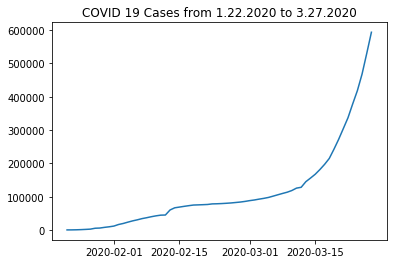

In [70]:
plt.plot(daily_cases)
plt.title("COVID 19 Cases from 1.22.2020 to 3.27.2020")

In [71]:
#Restructuring data into a dataframe
df = daily_cases.to_frame()
#df.reset_index(level=0, inplace=True)
#df.columns = ['Date','Confirmed Cases']
#df.head()

In [73]:
df.columns = ['Confirmed Cases']

In [74]:
df.head() #using datetime as index

,Confirmed Cases
2020-01-22,555
2020-01-23,654
2020-01-24,941
2020-01-25,1434
2020-01-26,2118


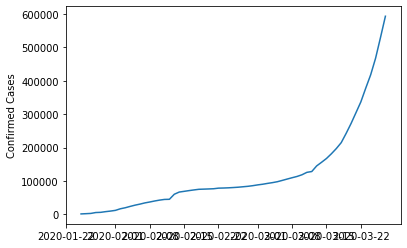

In [159]:
#Rough EDA of what Confirmed Cases overtime looks like
#sns.lineplot(x=df.index,y='Confirmed Cases',data=df)

In [77]:
df.info() #confirm that date is a datetime stamp

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2020-01-22 to 2020-03-27
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Confirmed Cases  66 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


In [78]:
len(df) #66 days of data

66

In [32]:
#For inputs let us try to by WEEKLY data, as we have 66 daily rows data
#We will take in the first 6 days as an input
#We will output the number of cases for the 7th day
#Have to make the data a multiple of 7 to make this easier to process, so we will remove the first three days of data

In [79]:
df = df.iloc[3:]

In [80]:
len(df) #now a multiple of 7, we have 9 weeks of data to deal with

63

In [82]:
df.head() #removed first three days

,Confirmed Cases
2020-01-25,1434
2020-01-26,2118
2020-01-27,2927
2020-01-28,5578
2020-01-29,6166


In [83]:
#will make our test data the last week worth of data
test_size = 7
test_ind = len(df) - test_size

In [84]:
#Split into train and test data
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [85]:
len(train)

56

In [86]:
train

,Confirmed Cases
2020-01-25,1434
2020-01-26,2118
2020-01-27,2927
2020-01-28,5578
2020-01-29,6166
2020-01-30,8234
2020-01-31,9927
2020-02-01,12038
2020-02-02,16787
2020-02-03,19881


In [87]:
len(test)

7

In [88]:
test

,Confirmed Cases
2020-03-21,304396
2020-03-22,336953
2020-03-23,378235
2020-03-24,418045
2020-03-25,467653
2020-03-26,529591
2020-03-27,593291


In [89]:
#Need to scale the data
#MinMaxScale to between 0 from 1
from sklearn.preprocessing import MinMaxScaler

In [90]:
scaler = MinMaxScaler()

In [91]:
#only want to fit to train data, cannot assume about prediction
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [92]:
scaled_train = scaler.transform(train)

In [93]:
scaled_test = scaler.transform(test)

In [94]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [96]:
len(test) #need to determine batch size
#length of batch needs to be less than test set

7

In [97]:
length = 5 #length of batch
generator = TimeseriesGenerator(scaled_train,scaled_train,
                                length=length,batch_size=1)

In [98]:
X,y = generator[0]

In [99]:
#X

array([[[0.        ],
        [0.00252771],
        [0.00551735],
        [0.01531406],
        [0.017487  ]]])

In [102]:
#len(X[0]) #given length of five days predict the sixth day

5

In [100]:
#y

array([[0.02512925]])

In [101]:
#scaled_train #after 0.017487 we have 0.02512925

array([[0.        ],
       [0.00252771],
       [0.00551735],
       [0.01531406],
       [0.017487  ],
       [0.02512925],
       [0.03138569],
       [0.03918685],
       [0.05673667],
       [0.06817048],
       [0.08299304],
       [0.09682521],
       [0.10849923],
       [0.12179186],
       [0.13187682],
       [0.14307412],
       [0.15272671],
       [0.16026548],
       [0.16181389],
       [0.21778929],
       [0.24187272],
       [0.24979952],
       [0.2579074 ],
       [0.265424  ],
       [0.27236411],
       [0.27422293],
       [0.27628501],
       [0.2785836 ],
       [0.28506177],
       [0.28648822],
       [0.2887166 ],
       [0.29183928],
       [0.29546824],
       [0.30048669],
       [0.30553472],
       [0.31255243],
       [0.32126637],
       [0.32842451],
       [0.33778885],
       [0.34621454],
       [0.35643623],
       [0.37090402],
       [0.38585593],
       [0.40054176],
       [0.41447001],
       [0.43305827],
       [0.45986896],
       [0.469

In [103]:
#Model Building Starts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [104]:
n_features = 1

In [105]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [107]:
#Create an early stopping mechanism, RNN takes a long amount of time
from tensorflow.keras.callbacks import EarlyStopping

In [108]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [109]:
#now passing in test data
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [110]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
51/51 [==============================] - 11s 225ms/step - loss: 0.0538 - val_loss: 0.7800
Epoch 2/20
51/51 [==============================] - 10s 190ms/step - loss: 0.0067 - val_loss: 0.0855
Epoch 3/20
51/51 [==============================] - 10s 191ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 4/20
51/51 [==============================] - 17s 329ms/step - loss: 8.9940e-04 - val_loss: 0.0600
Epoch 5/20
51/51 [==============================] - 15s 292ms/step - loss: 7.5015e-04 - val_loss: 0.0843


In [111]:
#Visualize the losses
losses = pd.DataFrame(model.history.history)

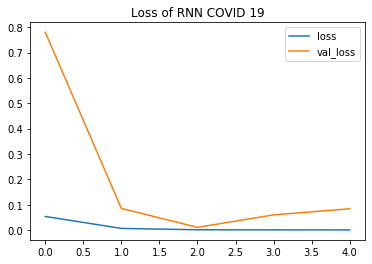

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = losses.plot()
plt.title("Loss of RNN COVID 19")
#fig = plt.figure(figsize=(90,45))
plt.savefig("Loss_RNN_COVID19.png")

In [114]:
test_predictions = [] #to store predictions

first_eval_batch = scaled_train[-length:] #grabbing last 5 days
current_batch = first_eval_batch.reshape((1,length,n_features)) 

for i in range(len(test)):
    
    #get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    #update batch with prediction, drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [115]:
#need to inverse scale to accurately depict predictions
true_predictions = scaler.inverse_transform(test_predictions)

In [116]:
test['Predictions'] = true_predictions

/Users/ramvegiraju/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
test 

,Confirmed Cases,Predictions
2020-03-21,304396,300560.078210
2020-03-22,336953,338683.279511
2020-03-23,378235,384319.340120
2020-03-24,418045,442628.209669
2020-03-25,467653,515346.473565
2020-03-26,529591,611008.510045
2020-03-27,593291,747126.431641


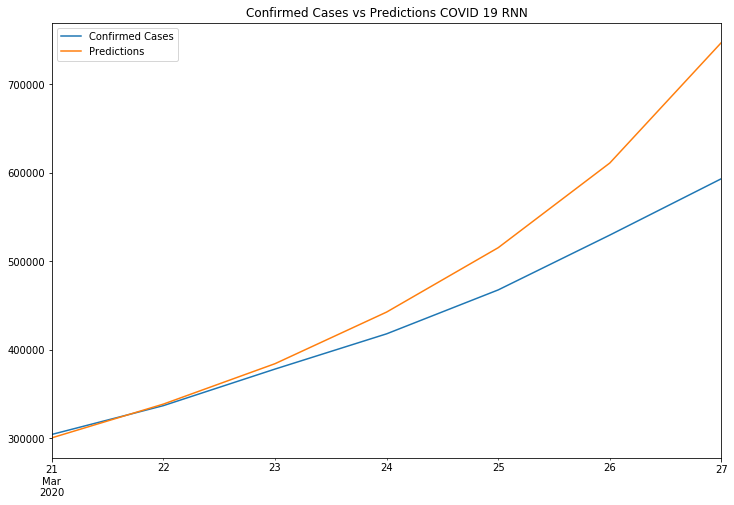

In [181]:
#Visualize actual vs predictions
test.plot(figsize=(12,8))
plt.title('Confirmed Cases vs Predictions COVID 19 RNN')
plt.savefig("ConfirmedCases_vs_Predictions.png")

In [120]:
#Forecast
#Have to repeat scaling with ALL the data
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [121]:
length = 5
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [122]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam',loss='mse')

model.fit_generator(generator,epochs=4) #select epochs based off of previous loss graph

Epoch 1/4
58/58 [==============================] - 13s 223ms/step - loss: 0.0397
Epoch 2/4
58/58 [==============================] - 12s 203ms/step - loss: 0.0075
Epoch 3/4
58/58 [==============================] - 11s 198ms/step - loss: 4.7088e-04
Epoch 4/4
58/58 [==============================] - 11s 185ms/step - loss: 4.2247e-04


In [144]:
forecast = []
periods = 7 #1 week forecast

first_eval_batch = scaled_train[-length:] 
current_batch = first_eval_batch.reshape((1,length,n_features)) 

for i in range(periods):
    
    #get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    #update batch with prediction, drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [145]:
forecast = scaler.inverse_transform(forecast)

In [146]:
df

,Confirmed Cases
2020-01-25,1434
2020-01-26,2118
2020-01-27,2927
2020-01-28,5578
2020-01-29,6166
...,...
2020-03-23,378235
2020-03-24,418045
2020-03-25,467653
2020-03-26,529591


In [147]:
forecast #next week of values

array([[313880.11473119],
       [353649.57861006],
       [404539.0729779 ],
       [472346.03308499],
       [561688.50385118],
       [686908.65363216],
       [867209.535079  ]])

In [149]:
#Need a datetime associated with the forecast
forecast_index = pd.date_range(start='2020-03-28',periods=periods,
                              freq="D")

In [150]:
forecast_index

DatetimeIndex(['2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03'],
              dtype='datetime64[ns]', freq='D')

In [151]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

In [152]:
forecast_df

,Forecast
2020-03-28,313880.114731
2020-03-29,353649.578610
2020-03-30,404539.072978
2020-03-31,472346.033085
2020-04-01,561688.503851
2020-04-02,686908.653632
2020-04-03,867209.535079


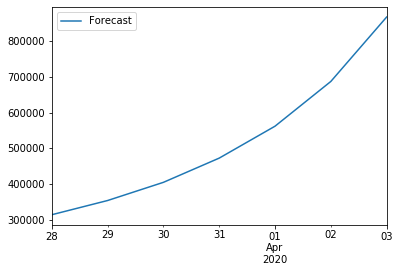

In [182]:
#df.plot()
forecast_df.plot()
plt.savefig("Forecast_COVID_NextWeek.png")

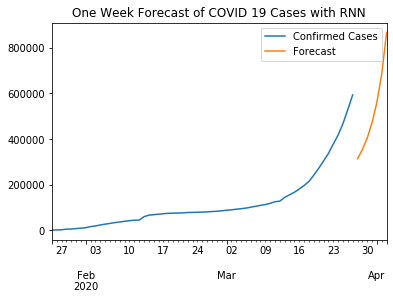

In [183]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.title("One Week Forecast of COVID 19 Cases with RNN")
plt.savefig("Forecast_ConfirmedCases.png")

In [1]:
###########################
# Model Conclusion: RNN was clearly a decent yet not the most accurate model in this scenario as it does start the
# forecast at a lower number than we are currently at for COVID 19 Cases. However, trend wise it does look similar and
# is forecasting nearly 800,000 confirmed cases within the next week globally. Next steps would be to understand the 
# theory of RNN and LSTMs better to be able optimize the model hyperparameters and mess with the data in more ways 
# with a long period of time. Next looking to incorporate a SARIMAx model in the designated time left to be able to 
# take in factors such as temperature. Also have to consider the fact of the limited patient data that is available 
# right now in regards to COVID as long as only a few months of data available even about general cases. In addition,
# time series data has many pit falls and factors we should look for more in EDA such as autocorrelation and such.
# Overall decent model prediction, will look to tune in the future with greater understanding. #
###########################